# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

## Load TCCW Cases

In [2]:
AU_to_Pa  = 2.9421015697e13 
Pa_to_bar = 1e-5
AU_to_bar = AU_to_Pa*Pa_to_bar 

In [3]:
cases_converged_thusfar = {'H1':True,'C1':True, 'Al1':True, 'Cu1': True, 'Be1': True, 'Au1': False, 'H2': True, 'H3': True, 'C2': False, 'C3': True, 'Al2': False, 'Al3': True,
 'Cu2': False, 'Cu3': True, 'H11': False, 'H21': False, 'H31': False, 'C11': False, 'C21': False, 'C31': False, 'Al11': False, 'Al21': False, 
 'Al31': False, 'Cu11': False, 'Cu21': False, 'Cu31': False, 'H12': True, 'H22': True, 'H32': False, 'C12': True, 'C22': False, 'C32': False, 
 'Al12': True, 'Al22': False, 'Al32': False, 'Cu12': True, 'Cu22': False, 'Cu32': False, 'H13': True, 'H23': True, 'H33': True, 'C13': True,
  'C23': True, 'C33': False, 'Al13': False, 'Al23': False, 'Al33': False, 'Cu13': True, 'Cu23': False, 'Cu33': False, 'H14': False, 'H24': False, 
  'H34': False, 'C14': False, 'C24': False, 'C34': False, 'Al14': False, 'Al24': False, 'Al34': False, 'Cu14': False, 'Cu24': False, 'Cu34': False,
   'H15': False, 'H25': False, 'H35': False, 'C15': False, 'C25': False, 'C35': False, 'Al15': False, 'Al25': False, 'Al35': False, 'Cu15': False,
    'Cu25': False, 'Cu35': False, 'H16': False}

In [4]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]


tccw_case = tccw_cases[2]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni_cc = tccw_case['Number Density [N/cc]']
Te_eV = tccw_case['Temperature [eV]']
Ti_eV = Te_eV
Z = tccw_case['Atomic Number']
Zbar = tccw_case['Zbar (TFDW)']
P_GP_AU  = tccw_case['p (Bar)']/AU_to_bar
A = tccw_case['Atomic Weight [a.u.]']
r_s_cc = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s_cc
if r_c>1:
    r_c=1e-5
print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te_eV, ni_cc, r_c))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
print("P  = {0:.3e} [bar] = {1:.3e} [AU]".format(P_GP_AU*AU_to_bar, P_GP_AU))


______________________________
Case num: 2 Case ID: Al1
Te = 1.000e+00 eV, n_i = 6.030e+22 1/cc, r_c/r_s = 0.218
Te = 1.160e+04 K, ρ = 2.983e+30 [g/cc] 
P  = 1.830e+05 [bar] = 6.220e-04 [AU]


### Create and run plasma

In [5]:
Zbar = 3

In [17]:
atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':0, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'alpha_Picard':0.1},
                 root_options={'options':{'maxfev':50000,'xtol':1e-14}})

Te_in_eV: 1.000
Ti_in_eV: 1.000


### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

(0.0, 15.17911784559138)

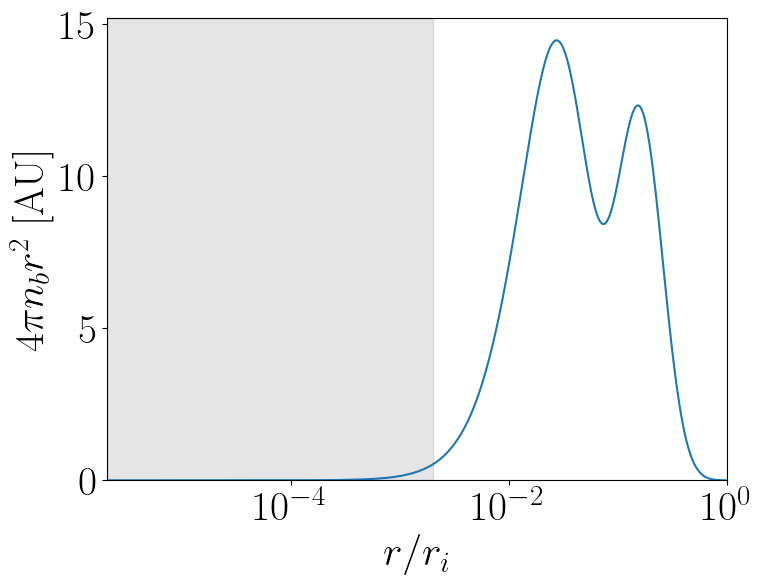

In [18]:
bound_file = "/home/zach/plasma/hnc/TCCW/data/Al_rs_3.000_T_1.000e+00eV.csv"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = np.array(AA_data['r[a_0]'])
AA_nb_AU_full = np.array(AA_data['n(bound)'])

# Only use some values for speed
min_r_to_use = 0.2*atom.hnc.r_array[0]*atom.qsp.ri # in AU
indcs = np.where(AA_r_AU_full > min_r_to_use)
AA_r_AU = AA_r_AU_full[indcs]
AA_nb_AU = AA_nb_AU_full[indcs]

# Plot bound states
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(AA_r_AU_full/atom.qsp.ri, 4*π*AA_nb_AU_full*AA_r_AU_full**2)
ax.axvspan(AA_r_AU_full[0]/atom.qsp.ri, min_r_to_use/atom.qsp.ri, color='k', alpha=0.1)
ax.set_xlabel(r'$r/r_i$')
ax.set_ylabel(r'$4 \pi n_b r^2$ [AU]')
ax.set_xscale('log')
ax.set_xlim(np.min(AA_r_AU_full/atom.qsp.ri), np.max(AA_r_AU_full/atom.qsp.ri))
ax.set_ylim(0, None)

[-1, 1, 0.002006331824171108, 1.0035161392181413]


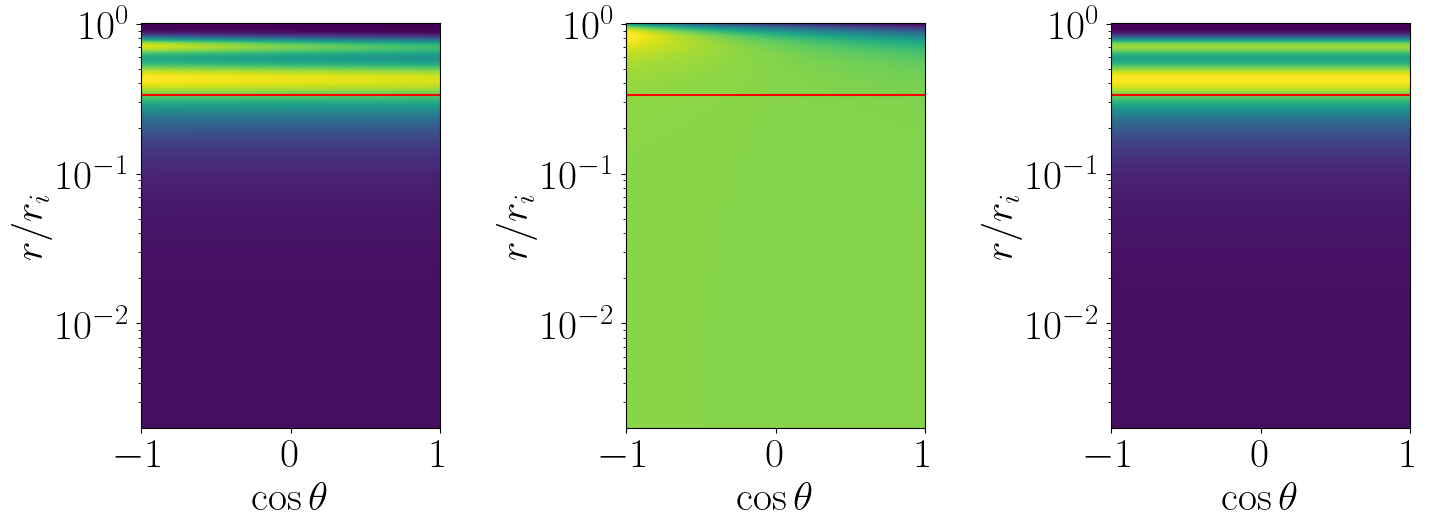

7.92591961877042

In [19]:
from scipy.integrate import dblquad, simpson
from scipy.interpolate import RegularGridInterpolator

def new_δβuei(r_sep_in_AU, verbose = False, only_Pauli=True):
    r_array = AA_r_AU #AU
    rs = atom.qsp.ri
    cosφ_array = np.linspace(-1,1,num=100)
    r_mesh, cosφ_mesh = np.meshgrid(r_array,cosφ_array, indexing='ij')

    nb_mesh = AA_nb_AU[:,np.newaxis] * np.ones_like(r_mesh)
    ree_mesh = np.sqrt( r_sep_in_AU**2 + r_mesh**2 + 2*r_mesh*r_sep_in_AU*cosφ_mesh  )
    
    if only_Pauli:
        # βu_ee_mesh = atom.qsp.βv_Pauli(ree_mesh/rs, atom.qsp.Λee)
        βu_ee_mesh = atom.βP_ee_func(ree_mesh/rs)
    else:
        βu_ee_mesh = atom.qsp.βvee( ree_mesh/rs  ) + atom.βP_ee_func(ree_mesh/rs) - atom.qsp.βv_Pauli(ree_mesh/rs, atom.qsp.Λee)
    
    integrand_mesh = 2*π* r_mesh**2 * nb_mesh*βu_ee_mesh
    
    if verbose:
        fig, axs = plt.subplots(1,3)
        extent = [-1,1, r_array[0]/atom.qsp.ri, r_array[-1]/atom.qsp.ri]
        print(extent)
        axs[0].imshow(r_mesh**2 * nb_mesh*βu_ee_mesh, origin='lower', extent=extent)
        axs[1].imshow(βu_ee_mesh, origin='lower', extent=extent)
        axs[2].imshow(r_mesh**2 * nb_mesh, origin='lower', extent=extent)
        for ax in axs:
            ax.set_ylabel(r'$r/r_i$')
            ax.set_xlabel(r'$\cos \theta$')
            ax.set_yscale('log')
            ax.plot(cosφ_array, np.ones_like(cosφ_array) * r_sep_in_AU/atom.qsp.ri ,'r')

        plt.tight_layout()
        plt.show()
    δβuei_simpson = simpson(simpson(integrand_mesh, axis=0, x=r_array), axis=0, x=cosφ_array)
    
#     δβuei_interp = RegularGridInterpolator( (r_array, cosφ_array), integrand_mesh  )
#     δβuei_integrand = lambda y, x : δβuei_interp((x, y)) # Weird convention, flipping not a mistake...
#     δβuei = dblquad(δβuei_integrand, r_array[0], r_array[-1], -1, 1)
    
    return δβuei_simpson#, δβuei
    
new_δβuei(1, verbose=True)

In [20]:
δβuei = np.array([new_δβuei(r_hnc*atom.qsp.ri, only_Pauli=False) for r_hnc in atom.hnc.r_array])
δβuei_Pauli = np.array([new_δβuei(r_hnc*atom.qsp.ri) for r_hnc in atom.hnc.r_array])

(-10000.0, 100.0)

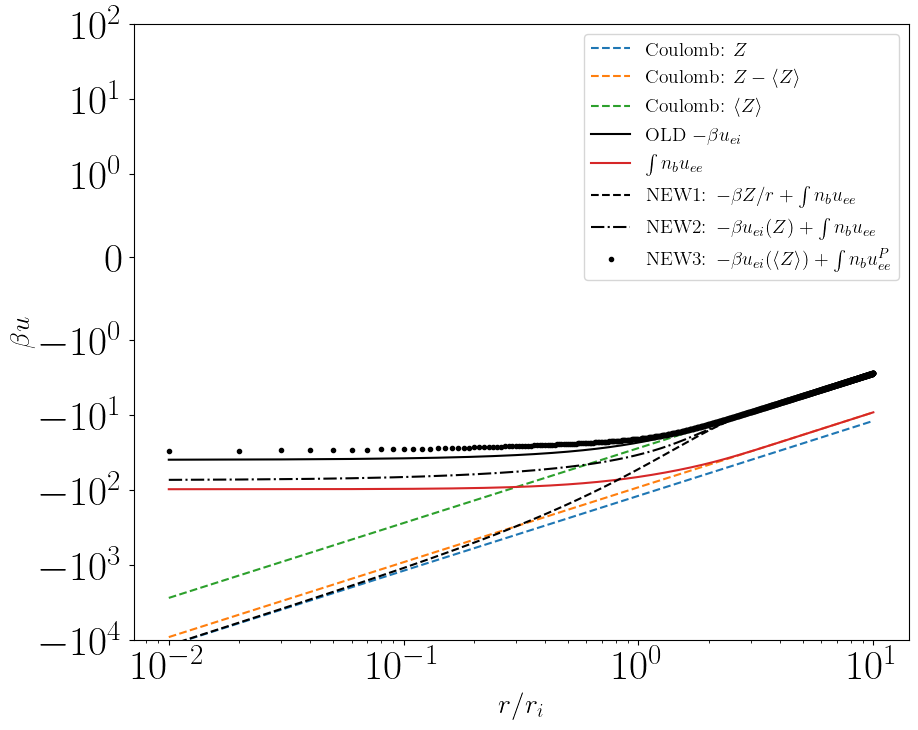

In [21]:
fig, ax = plt.subplots(figsize=(10,8))


ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * Z/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $ Z$')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * (Z-Zbar)/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $ Z-\langle Z \rangle$')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1] * Zbar/(atom.hnc.r_array*atom.qsp.ri),'--', label=r'Coulomb: $\langle Z \rangle$')
ax.plot(atom.hnc.r_array, atom.hnc.βu_r_matrix[0,1], 'k-',label=r'OLD $-\beta u_{ei}$')
ax.plot(atom.hnc.r_array, -δβuei, label=r' $\int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array, -1/atom.hnc.Temp_matrix[0,1]* Z/(atom.hnc.r_array*atom.qsp.ri) + δβuei,'k--' , label=r' NEW1: $-\beta Z/r + \int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array,  Z/Zbar*atom.hnc.βu_r_matrix[0,1] + δβuei,'k-.' , label=r' NEW2: $-\beta u_{ei}(Z) + \int n_b u_{ee}$ ')
ax.plot(atom.hnc.r_array,  atom.hnc.βu_r_matrix[0,1] + δβuei_Pauli,'k.' , label=r' NEW3: $-\beta u_{ei}(\langle Z \rangle) + \int n_b u^P_{ee}$ ')

ax.legend(fontsize=14)
ax.set_yscale('symlog', linthresh=1)
ax.set_xscale('log')

ax.set_ylabel(r"$\beta u$", fontsize=20)
ax.set_xlabel(r"$r/r_i$", fontsize=20)

ax.set_ylim(-1e4,1e2)

### Solving

In [22]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, c_s_k_guess=None):
    if c_s_k_guess == None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    
    def min_function(c_s_k_flat):
        c_s_k_matrix = custom_unflat(c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)

        return c_s_k_flat - new_c_s_k_flat

    # c_s_k_upper_bound_matrix = plasma.hnc.c_s_k_ 
    # c_s_k_guess = plasma_old.hnc.c_s_k_matrix.copy().flatten()
    # c_s_k_guess = plasma.hnc.c_s_k_matrix.copy().flatten()
    sol = least_squares(min_function, c_s_k_flat_guess, verbose=2)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = custom_unflat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None):
    if c_s_k_guess == None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=1e-8)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)


In [23]:
# atom1 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, 
#                  βu_options = {'add_bridge':False,'bridge':'yukawa', 'pseudopotential':True}, 
#                  qsp_options={'r_c':r_c},
#                  hnc_options={'kappa_multiscale':10, 'R_max':7,'N_bins':500},
#                  hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1},
#                  root_options={'options':{'maxfev':100,'xtol':1e-14}})

atom2 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, 
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':0, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})

atom3 =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar,find_βuee=True, 
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':0, 'R_max':10,'N_bins':1000},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.01,'verbose':True},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})


atom2.hnc.βu_r_matrix[0,1] = atom2.hnc.βu_r_matrix[0,1] + δβuei_Pauli
atom2.hnc.βu_r_matrix[1,0] = atom2.hnc.βu_r_matrix[1,0] + δβuei_Pauli
atom2.hnc.set_βu_matrix(atom2.hnc.βu_r_matrix)

atom3.hnc.βu_r_matrix[0,1] = atom3.hnc.βu_r_matrix[0,1] + δβuei
atom3.hnc.βu_r_matrix[1,0] = atom3.hnc.βu_r_matrix[1,0] + δβuei
atom3.hnc.set_βu_matrix(atom3.hnc.βu_r_matrix)


Te_in_eV: 1.000
Ti_in_eV: 1.000
Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:158: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


In [ ]:
# atom1.run_hnc(newton=False)
# # solve_least_squares(atom1, np.linspace(atom1.hnc.k_array[0], atom1.hnc.k_array[-1], num=20))
# solve_least_squares(atom1, np.linspace(atom1.hnc.k_array[0], atom1.hnc.k_array[-1], num=100))

In [24]:
# atom2.run_hnc(newton=False)
solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=100))
# solve_least_squares(atom2, np.linspace(atom2.hnc.k_array[0], atom2.hnc.k_array[-1], num=200))

/home/zach/plasma/hnc/hnc/hnc.py:533: RuntimeWarning: overflow encountered in exp
  h_r_matrix = -1 + np.exp(γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2128e+10                                    8.40e+09    
       1             10         1.2109e+10      1.91e+07       6.74e-01       5.29e+09    
       2             11         1.2108e+10      2.94e+05       1.69e-01       1.03e+10    
       3             12         1.2108e+10      6.44e+05       4.21e-02       1.28e+10    
       4             16         1.2108e+10      0.00e+00       0.00e+00       1.28e+10    
`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.2128e+10, final cost 1.2108e+10, first-order optimality 1.28e+10.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.193e+05 -1.901e+03 ... -2.992e-02 -1.089e-02]
           x: [-4.172e+04 -9.316e+01 ... -2.065e-09  1.285e-09]
        cost: 12107822380.299715
         jac: [[ 2.282e+00  1.487e+02 ... -0.000e+00

In [86]:
# c_s_k_3 = atom3.hnc.c_s_k_matrix.copy()
# c_s_k_4 = atom3.hnc.c_s_k_matrix.copy()
# atom3.run_hnc(c_s_k_guess = atom3.hnc.c_s_k_matrix.copy(), newton=False)
# atom3.run_hnc(c_s_k_guess = c_s_k_3.copy(), newton=False)
# atom3.run_hnc(newton=False)
# solve_least_squares(atom3, np.linspace(atom3.hnc.k_array[0], atom3.hnc.k_array[-1], num=100))
solve_least_squares(atom3,np.linspace(atom3.hnc.k_array[0], atom3.hnc.k_array[-1], num=200))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3724e+01                                    2.90e+04    
       1              6         2.9392e+01      4.43e+01       3.36e-01       7.59e+03    
       2              7         1.5877e+01      1.35e+01       6.72e-01       4.17e+03    
       3              9         1.5529e+01      3.48e-01       3.36e-01       5.67e+03    



KeyboardInterrupt



In [ ]:
# # Run Ornstein-Zernike version
# atom_oz = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, 
#                  βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':True}, 
#                  qsp_options={'r_c':r_c},
#                  hnc_options={'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 'oz_method':'standard'},
#                  hnc_solve_options={'alpha_Picard':0.25,'num_iterations':10000})
# atom_oz.run_hnc()
# # atom.get_cp()

In [ ]:
# atom_oz.run_onlyion_hnc()

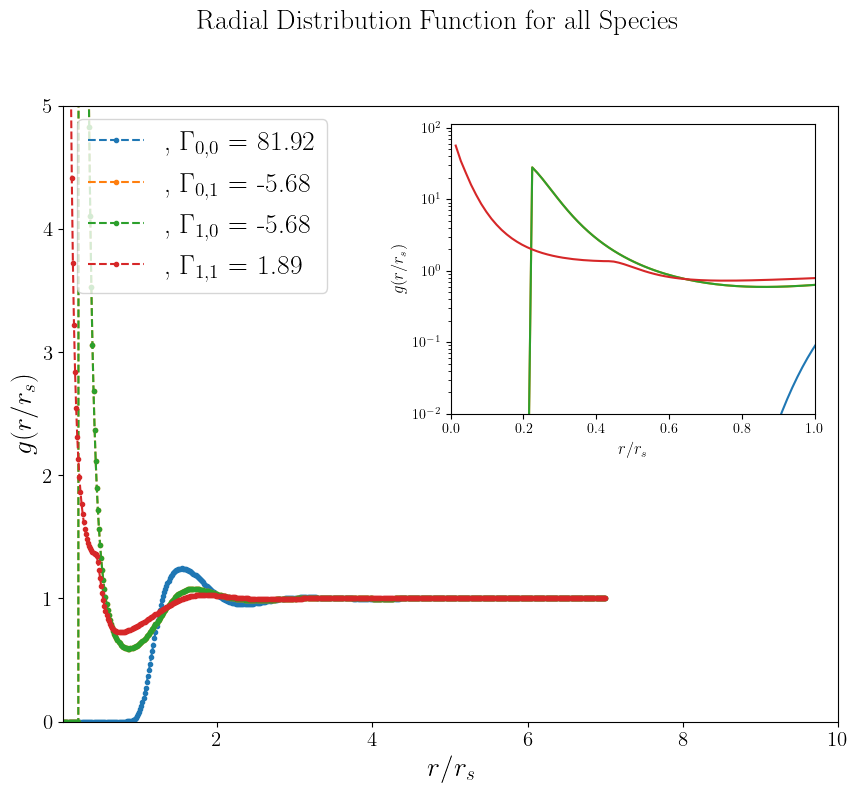

In [24]:
atom1.hnc.plot_g_all_species()

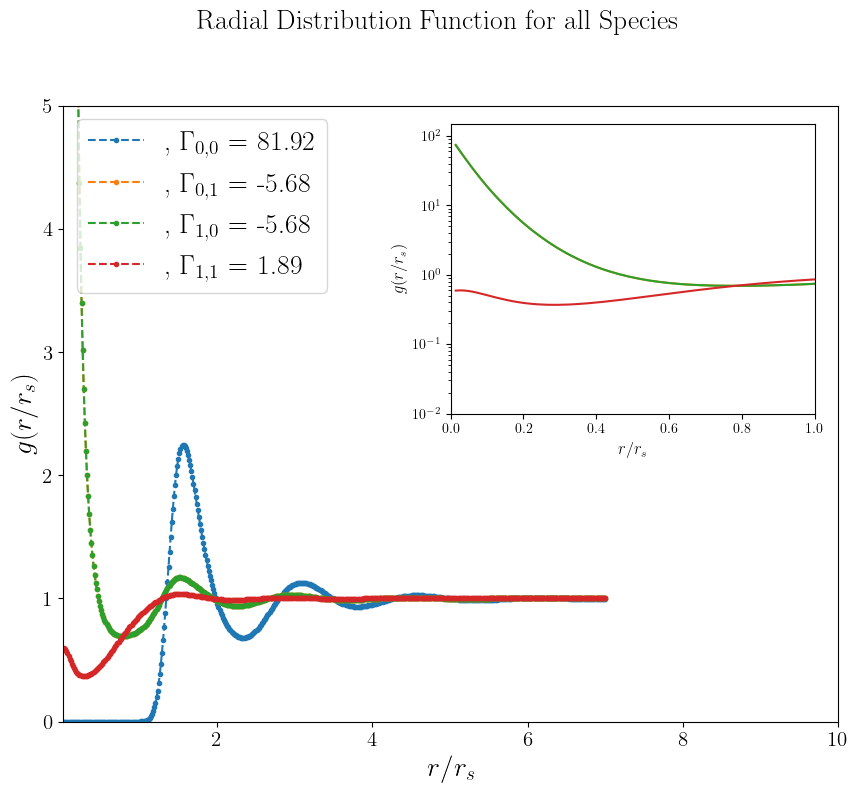

In [15]:
atom2.hnc.plot_g_all_species()

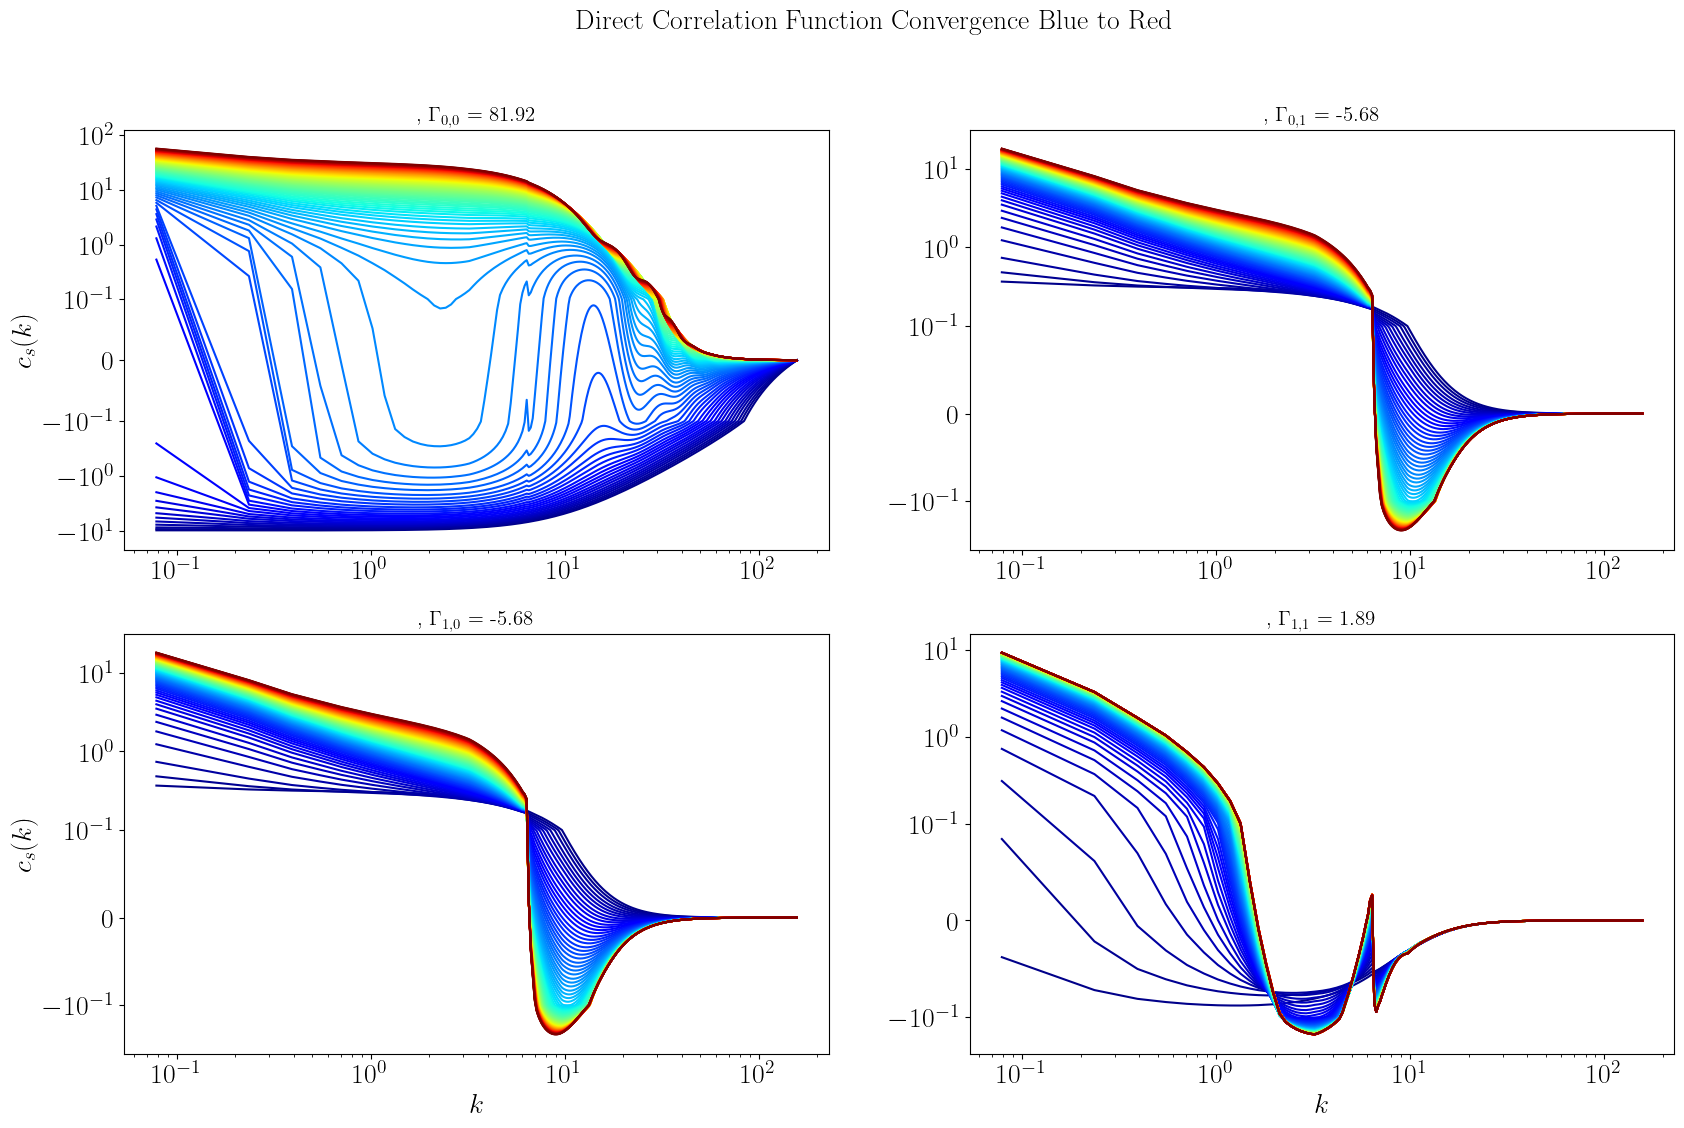

In [85]:
atom3.hnc.plot_species_convergence_csk(n_slices=100)

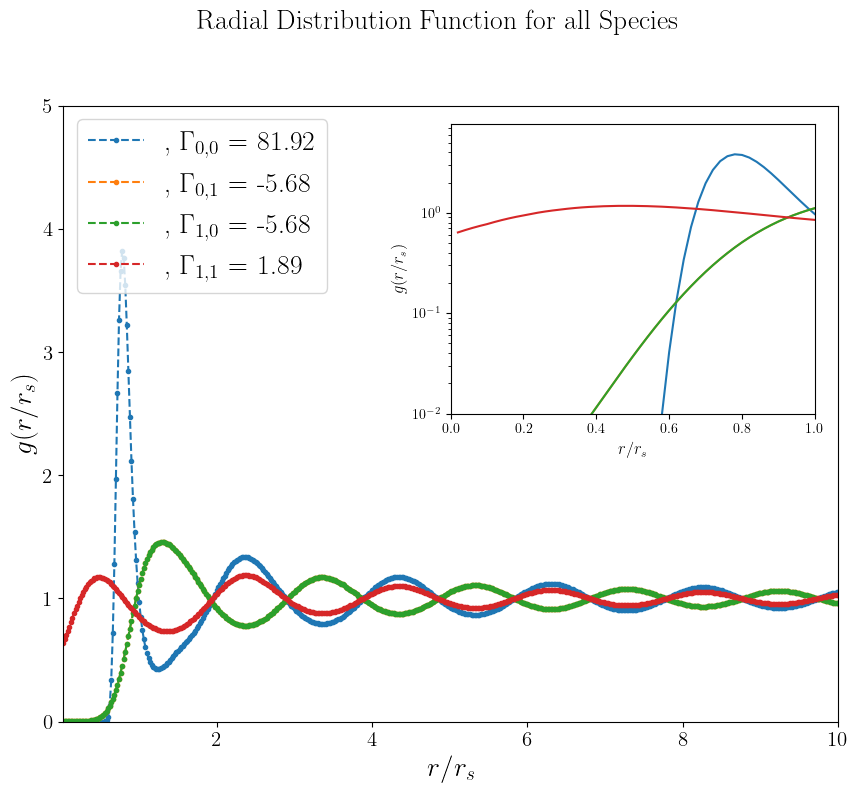

In [87]:
atom3.hnc.plot_g_all_species()

In [17]:
MD_data = read_csv("/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt",  header=1)
MD_data.columns=['r','g']
MD_data

,r,g
0,0.980066,0.004092
1,1.059801,0.009002
2,1.106312,0.031097
3,1.179402,0.134206
4,1.212625,0.247136
5,1.285714,0.576105
6,1.338870,0.892799
7,1.392027,1.145663
8,1.458472,1.413257
9,1.485050,1.481997


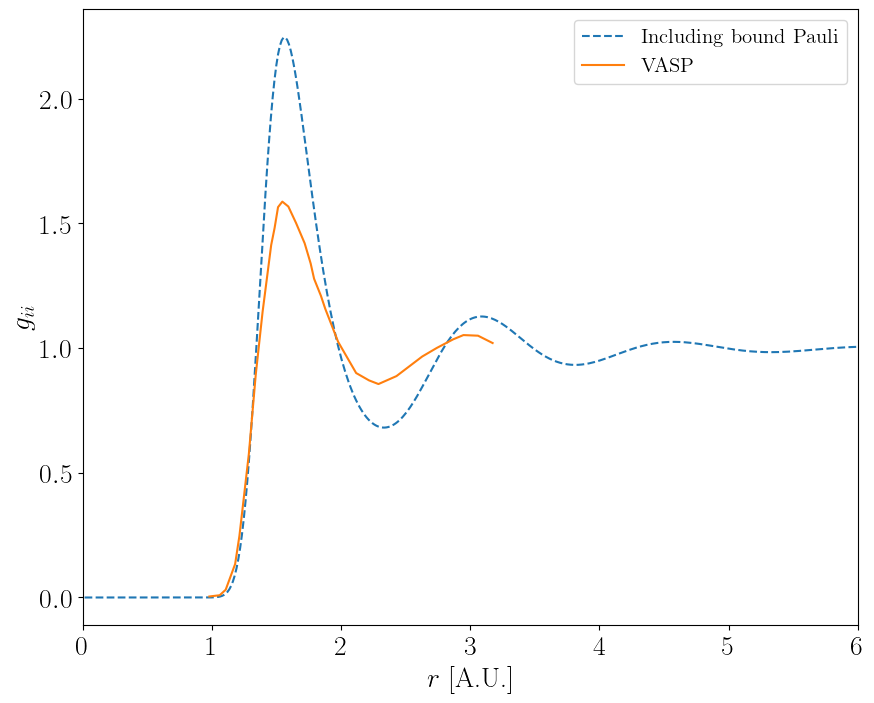

In [18]:
# AA_data = read_csv("/home/zach/plasma/atoMEC/examples/density.csv", delim_whitespace=True, header=0)

fig, ax = plt.subplots(figsize=(10,8))
# nf_0 = Zbar/(4/3*np.pi*atom.qsp.ri**3)
# ax.plot(AA_data['r[a_0]'], np.array(AA_data['n[unbound]'])/nf_0,'k.' ,label="AA" )
# ax.plot(atom_2e.hnc.r_array*atom_2e.qsp.ri, atom_2e.hnc.h_r_matrix[0,0]+1,'--', label='2 electron SVT ')
# ax.plot(atom1.hnc.r_array, atom1.hnc.h_r_matrix[0,0]+1,'--', label='Ashcroft Pseudopotential')
ax.plot(atom2.hnc.r_array, atom2.hnc.h_r_matrix[0,0]+1,'--', label='Including bound Pauli')
# ax.plot(atom3.hnc.r_array, atom3.hnc.h_r_matrix[0,0]+1,'--', label='No bound or psuedo')
# ax.plot(atom_long.hnc.r_array, atom_long.hnc.h_r_matrix[0,0]+1,'-.', label='1 electron SVT-long ')
# ax.plot(atom_oz.hnc.r_array, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='1 electron OZ ')
# ax.plot(atom.hnc.r_array, atom_oz.onlyion_hnc.h_r_matrix[0,0]+1,'--', label='Only Ion')
ax.plot(MD_data['r'], MD_data['g'], label='VASP')

# ax.plot(atom_oz.hnc.r_array*atom_oz.qsp.ri, atom_oz.hnc.h_r_matrix[0,0]+1,'--', label='my OZ CHNC')

ax.set_xlim(0,6)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r$ [A.U.]',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

## Born Green Viscocity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


In [ ]:
from scipy.integrate import simpson

def get_ηBG(plasma):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    ##
    fig, ax = plt.subplots()
    ax.plot(r_array, dφdr*r_array**4)
    ###
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

η_SI = get_ηBG(atom2)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
print(f"SI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
print(f"CGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")

# Plot Fixed Neutrality Issue βu_eff

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

atom.hnc.invert_HNC_OZ([1])
βu_r_raw = atom.hnc.βueff_r_matrix[0,0]
βu_r_raw_fix1 = βu_r_raw - βu_r_raw[-1]
βu_r_raw_fix2 = βu_r_raw - (βu_r_raw[-1]*atom.hnc.r_array[-1])/atom.hnc.r_array
tapering_func = lambda r: np.exp( -0.02*r**2/(5-r))
βu_r_raw_fix3 = βu_r_raw*tapering_func(atom.hnc.r_array)
βu_r_raw_fix4 = βu_r_raw_fix1*tapering_func(atom.hnc.r_array)


fig, axs  = plt.subplots(1,2,figsize=(20,8))
yukawa_matrix = (atom_long.hnc.Gamma[:,:,np.newaxis]/atom_long.hnc.r_array * np.exp(-atom_long.hnc.r_array*atom_long.qsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]

axs[0].set_title(r"$\beta u$")
axs[0].plot(atom.hnc.r_array, βu_r_raw,'k--', label='Raw')
axs[0].plot(atom_long.hnc.r_array, atom_long.hnc.βueff_r_matrix[0,0],'k-.', label='Long')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix1, label=r'Constant Shift to $\beta u_{eff}$')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix2 , label=r'Subtraction of Coulomb directly')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix3, label=r'Tapered raw')
axs[0].plot(atom.hnc.r_array, βu_r_raw_fix4, label=r'Tapered shifted')
axs[0].plot(atom_long.hnc.r_array, yukawa_matrix[0,0],'-.', label='Yukawa')

axs[1].set_title(r"$F$")
dudx = lambda u: -(u[1:]-u[:-1])/atom.hnc.del_r
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw),'k--', label='Raw')
axs[1].plot(atom_long.hnc.r_array[1:], dudx(atom_long.hnc.βueff_r_matrix[0,0]),'k-.', label='Long')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix1), label=r'Constant Shift to $\beta u_{eff}$')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix2) , label=r'Subtraction of Coulomb directly')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix3), label=r'Tapered raw ')
axs[1].plot(atom.hnc.r_array[1:], dudx(βu_r_raw_fix4), label=r'Tapered shifted')
βueff_r_header="r/r_i \t\t\t βuii_eff(r/r_i)"
np.savetxt("./fits/{0}_βu_eff_raw.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw]).T, header=βueff_r_header)
np.savetxt("./fits/{0}_βu_eff_shifted.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw_fix1]).T, header=βueff_r_header)
np.savetxt("./fits/{0}_βu_eff_tapered.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw_fix3]).T, header=βueff_r_header)
np.savetxt("./fits/{0}_βu_eff_shifted_tapered.txt".format(case_id), np.array([atom.hnc.r_array, βu_r_raw_fix4]).T, header=βueff_r_header)

axs[1].set_xlim(4,10)

for ax in axs:
    ax.set_yscale('symlog',linthresh=1e-8)

    ax.legend(fontsize=15)


### Plot $\beta u^{eff}$

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')
def make_gij(ax):
    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,0]+1,'-', label=r'$g_{ii}$')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[0,1]+1,'--', label=r'$g_{ei}$')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.h_r_matrix[1,1]+1,':', label=r'$g_{ee}$')

    # ax.set_yscale('symlog', linthresh=5)
    ax.set_xlim(0,10)
    ax.set_ylim(-0.05,5)

    ax.set_xlabel(r"$r$ [AU]")#, fontsize=25)
    ax.set_ylabel(r"$g_{ij}$")#, fontsize=25)
    ax.legend()

fig, ax = plt.subplots()
make_gij(ax)
plt.savefig("gij_Al1.png")

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

atom.hnc.invert_HNC_OZ([1])
def make_βu(ax):
    yukawa_matrix = (atom.hnc.Gamma[:,:,np.newaxis]/atom.hnc.r_array * np.exp(-atom.hnc.r_array*atom.qsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
    coulomb_matrix = (atom.hnc.Gamma[:,:,np.newaxis]/atom.hnc.r_array) [:-1,:-1]

    ax.plot(atom.hnc.r_array*atom.qsp.ri, atom.hnc.βueff_r_matrix[0,0],'-', label='HNC Inversion')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, yukawa_matrix[0,0],'-.', label='Yukawa')
    ax.plot(atom.hnc.r_array*atom.qsp.ri, coulomb_matrix[0,0],'--', label='Coulomb')

    ax.set_yscale('symlog', linthresh=1)

    ax.set_xlabel(r"$r$ [AU]")#, fontsize=25)
    ax.set_ylabel(r"$\beta u_{\rm eff}$")#, fontsize=25)
    ax.legend()

fig, ax = plt.subplots()
make_βu(ax)
plt.savefig("βu_Al1.png")

### Now Plot Both Together

In [ ]:
plt.style.use('~/plasma/mpl_styles/paper.mplstyle')

fig, axs = plt.subplots(1,2, figsize=(18,8))

make_gij(axs[0])
make_βu(axs[1])
plt.tight_layout()
plt.savefig("βu_gij_Al1.png")


# Run Many Cases

In [ ]:

for tccw_case in tccw_cases[6:]:
    α = 0.1
    case_converged=False
    case_attempts=0
    case_num= tccw_case[' ']
    case_id = tccw_case['Case ID']
    ni_cc = tccw_case['Number Density [N/cc]']
    Te_eV = tccw_case['Temperature [eV]']
    Ti_eV = Te_eV
    Z = tccw_case['Atomic Number']
    Zbar = tccw_case['Zbar (TFDW)']
    P_GP_AU  = tccw_case['p (Bar)']/AU_to_bar
    A = tccw_case['Atomic Weight [a.u.]']
    r_s_cc = tccw_case['Wigner-Seitz Radius [cm]']
    r_c = tccw_case['Average-Bound Radius [cm]']/r_s_cc
    if r_c>1:
        r_c=1e-5
    print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
    print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te_eV, ni_cc, r_c))
    print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
    print("P  = {0:.3e} [bar] = {1:.3e} [AU]".format(P_GP_AU*AU_to_bar, P_GP_AU))
    
    α = 1
    converged=False
    while not converged:
        atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, 
                     βu_options = {'add_bridge':True}, 
                     qsp_options={'r_c':r_c},
                     hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000},
                     hnc_solve_options={'alpha_Picard':α})
        atom.run_hnc()
        if atom.hnc.newton_succeed==True:
            converged=True
        else:
            α*=0.5
            
    atom.get_cp()

# Only Ion

In [ ]:
atom.run_onlyion_hnc()

In [ ]:
atom.onlyion_hnc.plot_species_convergence_g()

In [ ]:
# c_s_k_guess = atom.hnc.c_s_k_matrix.copy()*0
c_s_k_guess[0,0] = atom.onlyion_hnc.c_s_k_matrix[0,0]*0.


atom.run_hnc(c_s_k_guess = c_s_k_guess)


# Make atom

In [ ]:
Zbar_list  = np.linspace(3,Zbar, num=100)
# Zbar_list = [1,3]
atom_list= []
for i, Zbar_i in enumerate(Zbar_list):
    print("Zbar = {0:.3f}".format( Zbar_i ))
    
    atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar_i, 
                 βu_options = {'add_bridge':True}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':10},
                 hnc_solve_options={'alpha_Picard':0.5})
    if i>=1:
        Z2_matrix = [[Zbar_list[i]]]
        guess_2 = 
        c_s_k_guess = atom_list[-1].hnc.c_s_k_matrix
        c_s_k_guess[0,0] *= (Zbar_list[i]/Zbar_list[i-1])**2 
        c_s_k_guess[0,1] *= (Zbar_list[i]/Zbar_list[i-1])**1 
        c_s_k_guess[1,0] *= (Zbar_list[i]/Zbar_list[i-1])**1
#         c_s_k_guess[0,0] *= 0
    else:
        c_s_k_guess *=0
    atom.run_hnc(c_s_k_guess=c_s_k_guess)
    atom_list.append( atom )

In [ ]:
fig, axs = plt.subplots(2, 2, facecolor='w', figsize=(10,8) )

atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix-atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 
atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix/atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 

for i in range(2):
    for j in range(2):
        for k, atom in enumerate(atom_list):
            color = plt.cm.viridis(k/len(atom_list))
            Z_factor = (Zbar_list[0]/Zbar_list[k])**-1
            axs[i, j].plot(atom.hnc.r_array, atom.hnc.c_s_k_matrix[i,j], '--',label= "Zbar", color= color)
            axs[i, j].plot(atom.hnc.r_array, Z_factor*atom_list[0].hnc.c_s_k_matrix[i,j],'.', label= "Zbar", color= color)
#             axs[i, j].plot(atom.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=2")
#             axs[i, j].plot(atom.hnc.r_array, atom6.hnc.c_s_k_matrix[i,j], label= "Zbar=6")
#         axs[i, j].plot(atom2.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j]-atom1.hnc.c_s_k_matrix[i,j], label= "Zbar=2/1")
#         axs[i, j].plot(atom2.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j]-atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=3/2")
#         axs[i, j].plot(atom2.hnc.r_array, atom3_guess[i,j] , 'k--', label= "Zbar=3 (guess)")
        
#         axs[i, j].plot(atom3.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j],'k', label= "Zbar=3")
#         axs[i, j].plot(atom100.hnc.r_array, atom80.hnc.c_s_k_matrix[i,j]-100/80*atom100.hnc.c_s_k_matrix[i,j], label= "80/100 eV")
#         axs[i, j].plot(atom100.hnc.r_array, atom60.hnc.c_s_k_matrix[i,j], label= "60 eV")
         
#         axs[i, j].plot(atom100.hnc.r_array, T_rescale[i,j]*atom100.hnc.c_s_k_matrix[i,j], label= "rescaled 100 eV")
        
        axs[i,j].set_xscale('log')
#         axs[i, j].set_yscale('symlog', linthresh=0.1)
#         axs[i, j].legend()
        
plt.tight_layout()

In [ ]:
atom.get_cp(ε_derivative=1e-6, ε_table=1e-1, N_table= 2 )

In [ ]:
fig, ax = plt.subplots()

# ax.plot(atom.hnc.r_array, atom.hnc.βueff_r_matrix[0,0])
ax.plot(atom.hnc.r_array, atom.hnc.h_r_matrix[0,0]+1)
# ax.set_yscale('symlog', linthresh=1)

###### Hydrogen H1

c_p = 1.667e+08 [J/m^3/K] = 1.667e+09 [erg/cc/K]


c_p^ideal = 2.064e+07 [J/m^3/K] = 2.064e+08 [erg/cc/K]

c_v = 1.229e+08 [J/m^3/K] = 1.229e+09 [erg/cc/K]


γ = cp/cv = 1.357e+00

###### Aluminum Al1

c_p = 5.560e+06 [J/m^3/K] = 5.560e+07 [erg/cc/K]

c_p^ideal = 2.081e+06 [J/m^3/K] = 2.081e+07 [erg/cc/K]

c_v = 3.559e+06 [J/m^3/K] = 3.559e+07 [erg/cc/K]

c_p_over_nkB = 6.678

c_v_over_nkB = 4.275

γ = cp/cv = 1.562e+00

##### Carbon C1

c_p = 1.005e+09 [J/m^3/K] = 1.005e+10 [erg/cc/K]

c_p^ideal = 1.729e+07 [J/m^3/K] = 1.729e+08 [erg/cc/K]

c_v = 7.410e+08 [J/m^3/K] = 7.410e+09 [erg/cc/K]

γ = cp/cv = 1.357e+00

##### Copper Cu1
c_p = 6.829e+07 [J/m^3/K] = 6.829e+08 [erg/cc/K]

c_p^ideal = 2.930e+06 [J/m^3/K] = 2.930e+07 [erg/cc/K]

c_v = 4.460e+07 [J/m^3/K] = 4.460e+08 [erg/cc/K]

γ = cp/cv = 1.531e+00

In [ ]:
# Compare to Ichimaru
n_AU = ni_cc * (1e2*aB)**3
E_over_nkBT = atom.U/( Te*N )
P_over_nkBT = atom.P/(Te*n_AU)
c_p_over_nkB = C_p_AU/N #c_p_SI_vol/k_B/(ni_cc*1e6)
E_over_nkBT, P_over_nkBT, c_p_over_nkB  

In [ ]:
# 2x2
#(16.078004224152146, 7.958852940677674, 20.391840227664225)
# 3x3
#(17.29156071613095, 9.41653222069282, 19.954770080816058)
# 4x4
#(17.29156071613095, 9.41653222069282, 20.31577883096223)
# 6x6
#(17.29156071613095, 9.41653222069282, 20.341775951597302)



In [ ]:
#cp units are J/K/m^3

In [ ]:
c_p_SI_vol *J_to_erg*1e-6 # from J/K/m^3 to erg/K/cc

In [ ]:
(c_p_over_nkB*ni_cc * k_B*1e6)/1e8 # in erg/

In [ ]:
# Ideal
# (1.503495387998133, 1.0020009999999997, 2.5033223241241656)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom = atom_highres

In [ ]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
luke_r

In [ ]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, 5)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()